# Проект по А/B-тестированию

## Постановка задачи

Проведение оценки результатов A/B-теста. В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.
- оценка корректности проведения теста.
- анализ результатов теста.
Чтобы оценить корректность проведения теста, проверим:
- пересечение тестовой аудитории с конкурирующим тестом;
- совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

## Предобработка данных

Загризим библиотеки

In [99]:
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math as mth
import seaborn as sns
from datetime import datetime

from scipy import stats as st

### Датасет ab_project_marketing_events

Загрузим календарь маркетинговых событий на 2020 год.

Структура файла:
- name — название маркетингового события;
- regions — регионы, в которых будет проводиться рекламная кампания;
- start_dt — дата начала кампании;
- finish_dt — дата завершения кампании.

In [100]:
mark_ev = pd.read_csv ('/datasets/ab_project_marketing_events.csv')
mark_ev

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [101]:
mark_ev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


Преобразуем необходимые колонки в формат даты.

In [102]:
mark_ev['start_dt'] = pd.to_datetime(mark_ev['start_dt'], format='%Y-%m-%d')
mark_ev['finish_dt'] = pd.to_datetime(mark_ev['finish_dt'], format='%Y-%m-%d')

### Датасет final_ab_new_users.csv

Загрузим датасет со всеми пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года.

Структура файла:
- user_id — идентификатор пользователя;
- first_date — дата регистрации;
- region — регион пользователя;
- device — устройство, с которого происходила регистрация.

In [103]:
users = pd.read_csv ('/datasets/final_ab_new_users.csv')
users.head(5)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [104]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [105]:
users.duplicated().sum()

0

В таблице нет пропусков и дубликатов.

Заменим тип данных на числовой

In [106]:
users['first_date'] = pd.to_datetime(users['first_date'], format='%Y-%m-%d')

In [107]:
users['first_date'].min()

Timestamp('2020-12-07 00:00:00')

In [108]:
users['first_date'].max()

Timestamp('2020-12-23 00:00:00')

Посмотрим на распределение по регионам

In [109]:
users['region'].value_counts()

EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: region, dtype: int64

Посмотрим с каких устройств заходили пользователи

In [110]:
users['device'].value_counts()

Android    27520
PC         15599
iPhone     12530
Mac         6084
Name: device, dtype: int64

Больше всего с Андроида и PC, далее идет iPhone   и Mac

### Таблица final_ab_events.csv

Загрузим датасет со всеми событиями новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:
- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

In [111]:
events = pd.read_csv ('/datasets/final_ab_events.csv')
events.head(5)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [112]:
events.duplicated().sum()

0

ДУбликатов не обнаружено.

In [113]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


В таблице есть пропущенные значения в колонке details

In [114]:
events.describe()

,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


Посмотрим на характер пропусков в колонке details

In [115]:
events.groupby('event_name')['details'].agg({'count'})

,count
event_name,
login,0
product_cart,0
product_page,0
purchase,62740


В столбце details указана сумма покупки, поэтому данные есть только в строках с событием purchase (транзакциии о покупках). Заполним нулевыми значениями.

In [116]:
events['details'] = events['details'].fillna(0)

Преобразуем колонки в тип даты и времени.

In [117]:
events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y-%m-%d %H:%M:%S')

In [118]:
events['date'] = events['event_dt'].dt.date
events.head(5)

,user_id,event_dt,event_name,details,date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07


### Таблица final_ab_participants.csv

Загрузим таблицу участников тестов.

Структура файла:
- user_id — идентификатор пользователя;
- ab_test — название теста;
- group — группа пользователя.

In [119]:
participants = pd.read_csv ('/datasets/final_ab_participants.csv')
participants.head(5)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [120]:
participants.duplicated().sum()

0

In [121]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


Дубликатов и пропусков не обнаружено

Сгруппируем датасет по названию теста, посчитаем уникальных пользователей.

In [122]:
participants.groupby(['ab_test']).agg({'user_id': 'nunique'})

,user_id
ab_test,
interface_eu_test,11567
recommender_system_test,6701


В датасете есть данным по двум разным тестам. Мы анализируем только один из них: **recommender_system_test**. В тесте приняли участие 6701 чел.

### Соответствие данных требованиям технического задания.

- Название теста: recommender_system_test;
- Группы: А (контрольная), B (новая платёжная воронка);
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Аудитория: 15% новых пользователей из региона EU;
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- Ожидаемое количество участников теста: 6000.
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
- конверсии в просмотр карточек товаров — событие product_page
- просмотры корзины — product_cart
- покупки — purchase.
- Загрузите данные теста, проверьте корректность его проведения и проанализируйте полученные результаты.

Соответствие данных требованиям технического задания. Проверим корректность всех пунктов технического задания.

Проверим дату остановки теста.

In [123]:
print (events['date'].min())
print (events['date'].max())

2020-12-07
2020-12-30


По техническому заданию тестирование должно быть завершено 4 января, однако у нас максимальная дата 30.12 в датасете. Возомжно часть данных была не выгружена или утеряна либо же пользователи перестали иметь клиентскую активность уже на 10ый день теста.

Проверим даты набора новых пользователей. Согласно тех. заданию 2020-12-21:

In [124]:
users['first_date'].max()

Timestamp('2020-12-23 00:00:00')

In [125]:
users = users[users['first_date'] <= '2020-12-21']

Для того, чтобы проверить процентное соотношение аудитории: 15% новых пользователей из региона EU, возьмем датафрейм со всеми новыми клиентами и очищенный датафрейм.

In [126]:
dt = participants.merge(users, on='user_id')
dt = dt.merge(events, on='user_id')
print (dt['user_id'].nunique())

12636


Всего в датафрейме 12636 уникальных пользователей. Отберем пользователей которые входят в нужный тест (recommender_system_test) и европейский регион(EU), согласно техническому заданию.

In [127]:
rs = dt.query('ab_test == "recommender_system_test"')
rs = rs.query('region == "EU"')

print (rs['user_id'].nunique())

3481


Всего 3481 уникальный пользователей вошли в очищенный датафрейм, согласно дате, региону, тесту. Это те пользователи, которые имели пользовательскую активность в данный период.

In [128]:
fraction_eu = users[users['region'] == 'EU']
fraction_rs = users.merge(participants, on='user_id', how='left').dropna()
fraction_rs = fraction_rs[fraction_rs['ab_test'] == 'recommender_system_test']

len(fraction_rs)/len(fraction_eu)*100

15.826641473783656

Доля участников составила 15% и посчитано верно.

Посмотрим время проведения теста. Убедимся, что оно не совпадает с маркетинговыми и другими активностями.

Посмотрим какие маркетинговые события происходили в периоды по тех.заданию:

In [129]:
mark_ev[(mark_ev['start_dt'] >= '2020-12-07') & (mark_ev['start_dt'] <= '2021-01-04')]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Для Европы события в рамках теста имеют сильное пересечение с рождественской маркетинговой активностью (Christmas&New Year Promo). Этот факт дополнительно может повлиять на результаты теста. 

Проверим аудиторию теста. Удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно.

In [130]:
# создадим датафрейм, где посчитаем, в скольких тестах принимал участие каждый пользователь 
cross = dt.groupby('user_id', as_index=False).agg({'ab_test': 'nunique'})
cross = cross.rename(columns={'ab_test': 'number_of_tests'})
cross.head()

,user_id,number_of_tests
0,0002CE61FF2C4011,1
1,001064FEAAB631A1,2
2,0010A1C096941592,1
3,001E72F50D1C48FA,1
4,002412F1EB3F6E38,1


In [131]:
# присоеденим данные по количеству тестов к основному датасету
rs = rs.merge(cross, on='user_id')
rs.head()

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,date,number_of_tests
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07,1
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99,2020-12-25,1
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,0.00,2020-12-07,1
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,0.00,2020-12-25,1
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,0.00,2020-12-07,1


In [132]:
rs['user_id'].nunique()

3481

In [133]:
rs[rs['number_of_tests'] ==  2]['user_id'].nunique()

887

Из 3481 пользователей - 887 участвовало сразу в двух тестах одновременно. Нам не известно, как влиял на пользователей второй тест и влиял ли вообще, поэтому данные не исключаем.

Посмотрим на пересечения пользователей по группам, есть ли пользователи, которые попали в группу А и B одновременно.

In [134]:
a = rs.query('group == "A"')['user_id']
b = rs.query('group == "B"')['user_id']
print ('Всего уникальных пользователей группы А:', a.nunique())
print ('Всего уникальных пользователей группы B:', b.nunique())
print('Пересечения между пользователями групп А и В:', len(np.intersect1d(a, b)))

Всего уникальных пользователей группы А: 2604
Всего уникальных пользователей группы B: 877
Пересечения между пользователями групп А и В: 0


Пересечений между группами не найдено, пользователи распределены неравномерно по группам. Количество уникальных пользователей в группе А значительно превышает количество пользователей в группе В.

## Исследовательский анализ данных.

Проверим как распределено количество событий на пользователях в выборке.

In [135]:
# среднее количество событий на пользователя в группе А
a  = rs.query('group == "A"')
round(len(a) / a['user_id'].nunique())

7

In [153]:
# среднее количество событий на пользователя в группе B
b  = rs.query('group == "B"')
round(len(b) / b['user_id'].nunique())

6

Как число событий в выборках распределено по дням?

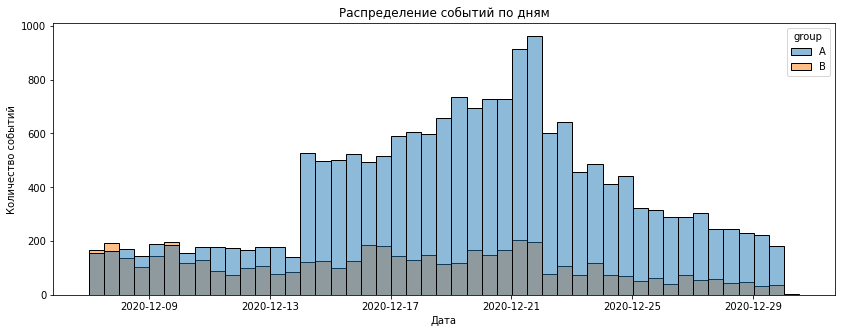

In [137]:
rs['event_dt'].dt.date
plt.figure(figsize=(14,5))
sns.histplot(x=rs['event_dt'], hue='group', data=rs)
plt.title ('Распределение событий по дням')
plt.xlabel ('Дата')
plt.ylabel ('Количество событий')
plt.show()

In [151]:
a = a.groupby('user_id').agg({'event_name':'count'}).reset_index().rename(columns={'event_name':'cnt_events'})
a.head()

,user_id,cnt_events
0,0010A1C096941592,12
1,00341D8401F0F665,2
2,003DF44D7589BBD4,15
3,00505E15A9D81546,5
4,006E3E4E232CE760,6


In [154]:
b = b.groupby('user_id').agg({'event_name':'count'}).reset_index().rename(columns={'event_name':'cnt_events'})
b.head()

,user_id,cnt_events
0,001064FEAAB631A1,6
1,005E096DBD379BCF,4
2,015D1E3BB893349D,6
3,015FF3EC72C1F4F6,2
4,01B0B891CA513468,12


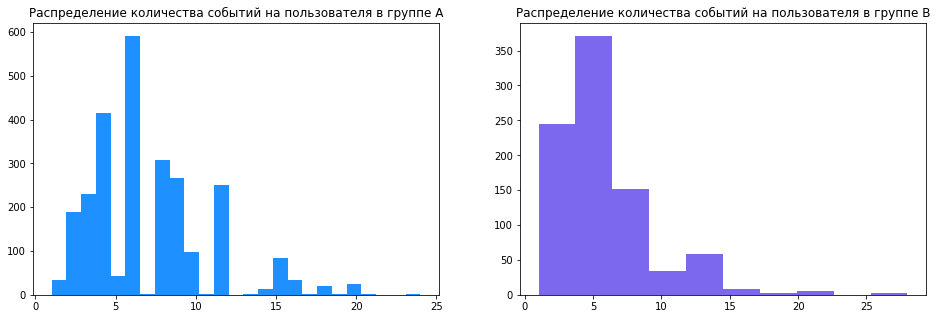

In [201]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].hist(data = a, x ='cnt_events', color='#1E90FF', bins=25)
axs[0].set_title('Распределение количества событий на пользователя в группе А')
axs[1].hist(data = b, x ='cnt_events',  color='#7B68EE')
axs[1].set_title('Распределение количества событий на пользователя в группе B')
plt.show()

Количество событий на пользователя в выборках распределены неравномерно.

Как меняется конверсия в воронке в выборках на разных этапах?

In [138]:
# создадим сводную таблицу с событиями по группам
rs_events = rs.pivot_table(index='event_name', values='user_id', columns='group', aggfunc='nunique').reindex(["login", "product_page", "product_cart", "purchase"])
                
# добавим столбец с общим числом событий
rs_events['total'] = rs_events.sum(axis=1)
rs_events

group,A,B,total
event_name,,,
login,2604,877,3481
product_page,1685,493,2178
product_cart,782,244,1026
purchase,833,249,1082


Всего 4 варианта событий:

- login - регистрация пользователя
- product_page - посещение страницы с товаром
- product_cart - добавление товара в корзину
- purchase - заказ

Некоторые пользователи делают заказ, пропуская шаг "добавление заказа в корзину". На сайте можно купить товар сразу, не добавляя его в корзину.

In [139]:
# порядок событий продуктовой воронки
order = ['login', 'product_page','product_cart', 'purchase']
# построим график продуктовой воронки с разделением по группам

fig = go.Figure()

for group in rs_events.iloc[:, :2].iteritems():
    fig.add_trace(go.Funnel(
        name = group[0],
        orientation = "h",
        y = order,
        x = group[1],
        textinfo = "value + percent previous",

    ))
    
fig.update_layout(
    title = 'Продуктовая воронка с конверсией к предыдущему шагу',
    autosize=True,
)

fig.show()

Исходя из построенной воронки мы определили, что по группам А и В:

- В страницу товаров перешли 1685 / 493 клиентов соответственно
- В корзине оказались 782 / 244 пользователей
- Оплатили 833/ 249 - оплат больше, чем переходов в корзину
- Покупку совершили 32% в группе А и 28% в группе В

Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

- Количество новых пользователей, которые участвуют в тесте,  меньше чем предполагалось 3481 вместо 6000
- Неравномерное распределение по группам: A - 2604, B - 877
- Неравномерное распределение количества событий на пользователя. 
- Влияние маркетинговых мероприятий
- Пересечение с другим тестом.

## Оценка результатов A/B-тестирования.

### Проверка статистической разницы долей z-критерием.

Проверим гипотезы равенства долей конверсии между группами A и B.

Сформулируем гипотезы:

- Нулевая гипотеза, H0: статистически значимых различий нет, доли одинаковые.
- Альтернативная гипотеза H1: статистически значимые различия есть, доли разные.

Пороговое значение alpha 0.05



Воспользуемся Z-критерием.


In [140]:
rs_events = rs_events.reset_index()
rs_events = rs_events[['A', 'B']]
rs_events

group,A,B
0,2604,877
1,1685,493
2,782,244
3,833,249


In [141]:
users_group = rs.groupby('group')['user_id'].nunique().reset_index()
users_group = users_group.set_index(users_group.columns[0])
users_group

,user_id
group,
A,2604
B,877


In [142]:
# используем функцию для z-test с поправкой Бонферрони
def z_test_bonferroni(group1, group2, event, alpha): 
    alpha_bonferroni = alpha / 4 # введём поправку на 3 этапа в воронке
    p1_event = rs_events.loc[event, group1]
    p2_event = rs_events.loc[event, group2] 
    p1_users = users_group.loc[group1, 'user_id'] 
    p2_users = users_group.loc[group2, 'user_id'] 
    p1 = p1_event / p1_users 
    p2 = p2_event / p2_users 
    difference = p1 - p2
    p_combined = (p1_event + p2_event) / (p1_users + p2_users) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_users + 1 / p2_users))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Проверка для события: {}, p-значение: {p_value:.7f}'.format(event, p_value=p_value))
    if (p_value < alpha_bonferroni):
        print("Отвергаем нулевую гипотезу о равенстве долей конверсии между группами")
    else:
        print("Не получилось отвергнуть нулевую гипотезу о равенстве долей конверсии между группами")

In [143]:
for event in rs_events.index:
    z_test_bonferroni('A', 'B', event, 0.05)
    print()

Проверка для события: 0, p-значение: nan
Не получилось отвергнуть нулевую гипотезу о равенстве долей конверсии между группами

Проверка для события: 1, p-значение: 0.0000069
Отвергаем нулевую гипотезу о равенстве долей конверсии между группами

Проверка для события: 2, p-значение: 0.2146919
Не получилось отвергнуть нулевую гипотезу о равенстве долей конверсии между группами

Проверка для события: 3, p-значение: 0.0465248
Не получилось отвергнуть нулевую гипотезу о равенстве долей конверсии между группами



/tmp/ipykernel_31/1158485474.py:12: RuntimeWarning:

invalid value encountered in double_scalars



## Выводы

Проведя предобработку и исследовательский анализ, выяснили:

- Количество пользвателей принявших участие в тесте не соответствует техническому заданию, почти в два раза меньше, чем требовалось. С
- Среди участников теста наблюдаются пересечение с другим тестом и маркетинговыми событиями. 
- Пользователи неравномерно распределены по группам. 
- Среднее количество событий на пользователя A и B групп различается.
- Количество событий в группе А резко повышается с 14 декабря, растёт до 21 декабря и достигает пика и далее снижается.
- Количество событий в группе В распределено достаточно равномерно с заметным снижением в последние 5 дней.
- В некоторых случаях, пользователи совершали оплату пропуская корзину. 

Исходя из построенной воронки мы определили, что по группам А и В:
- В страницу товаров перешли 1685 / 493 клиентов соответственно
- В корзине оказались 782 / 244 пользователей
- Оплатили 833/ 249 - оплат больше, чем переходов в корзину
- Покупку совершили 32% в группе А и 28% в группе В

Проверка статистической разницы долей z-критерием показала: доли конверсии между группой А и группой В для события "Страница продукта" имеет статистически значимую разницу. Результаты теста нельзя считать достоверными исходя из многочисленных нарушений по выборкам.